# Extended Data Fig. 8
- We recorded visual resposnes of habenula cells
- We presented full-field flashes, localizd bars (either horizontal or vertical), and the sun-and-bars scene slowly rotating about the fish in an opne-loop
- For each fish, concatenate data from different planes

In [1]:
# import modules
from utility import *
from pathlib import Path
import numpy as np
import flammkuchen as fl
from bouter import EmbeddedExperiment
from matplotlib import  pyplot as plt
from scipy.stats import binned_statistic
import colorcet as cc
import json
from tqdm import tqdm
import re

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# config matplotlib
config_rcparams()

In [34]:
## Parameters
# for cutting snippet
t_pre = 2
t_post = 10

# threshold to define light responsive cells
corr_thresh = 0.3

# stimulus parameter
# coded in metadata, but just assume them because painful to access them
bar_duraiton = 4.0  # in seconds
n_azi = 16 # possible azimuthal positions of the vertical bars
n_ele = 5  # possible elevations of the horizontal bars

max_azi = 120 # in deg
max_ele = 30 # in deg

# Analysis
## Data loading

In [27]:
master_path = Path('../data/ed08')
fish_list = get_fish_list(master_path, silent=True)

In [35]:
# Loop through all fish
data = []

for fish in fish_list:
    print('************')
    rec_list = list(fish.glob('20*_f*'))
    
    D = dict(stack=[], coords=[], flash_snip=[], bar_snip=[], norm_traces=[], z=[], mags=[])
    
    # Loop through all planes
    for path in rec_list:
        ### Retrieve Z info from the file name
        z = int(re.search('z[0-9]*', path.name)[0][1:])
        
        ### Load imaging data ###
        suite2p_data = fl.load(path / "data_from_suite2p_cellsonly.h5")
        t_i = fl.load(path / "time.h5")['t']
        
        # behavioral / stimulus data
        exp = EmbeddedExperiment(path / 'behavior')
        slog = exp['stimulus']['log']
        t_s = exp.stimulus_log['t'].to_numpy()

        # load mask
        mask_list = list(path.glob('manual_mask_*'))
        mask = np.load(mask_list[-1], allow_pickle=True)[()]['mask']
            
        ### Pre-process imaging data ###
        stack = suite2p_data['anatomy_stack'][0, :, :]
        x = suite2p_data['coords'][:, 2]
        y = suite2p_data['coords'][:, 1]
        
        in_mask = [mask[int(yy), int(xx)] for xx, yy in zip(x,y)]
        traces = suite2p_data['traces'][in_mask, :]
        x = x[in_mask]
        y = y[in_mask]
        norm_traces = (traces - np.mean(traces,axis=1)[:, None]) / np.std(traces,axis=1)[:, None]
        
        ### Select ROIs with flash responses ###
        flash_on = exp.stimulus_log['flash_flash_on'].to_numpy()
        flash_on_t = t_s[np.where(np.diff(flash_on)==1)[0]]
        flash_period = slog[0]['period']
        flash_snip, _ = cut_snip(norm_traces, t_i, flash_on_t, 0, flash_period, subtract_pre=False)
        
        mean_corr = []
        for i in range(len(x)):
            temp = flash_snip[:, i, :]
            C = np.corrcoef(temp)
            mean_corr.append(np.mean(C[np.triu(np.ones(C.shape),1)==1]))
        mean_corr = np.asarray(mean_corr)
        correlated = mean_corr > corr_thresh
        print(fish.name + ' plane {}, {} flash correlated ROI out of {}'.format(z, np.sum(correlated), len(x)))
        
        ### Pull out bar snippets ###
        bar_start_t = np.asarray([x['t_start'] for x in slog[2:-1]]) # assuming the ordering of "flash - interleave - many bars - scene rotation"
        bar_arr = np.asarray([x['orientation'] for x in slog[2:-1]]) + 1000 * np.asarray([x['bar_position'] for x in slog[2:-1]])
        unique_ba = np.unique(bar_arr)
        bar_id = np.asarray([np.where(unique_ba==x)[0][0] for x in bar_arr])
        bar_snip = np.asarray([cut_snip(traces, t_i, bar_start_t[bar_id==i], t_pre, t_post, subtract_pre=False)[0] for i in range(len(unique_ba))])
        t_snip = cut_snip(traces, t_i, bar_start_t[bar_id==i], t_pre, t_post, subtract_pre=False)[1]
        dff = (bar_snip - np.mean(bar_snip[:, :, :, t_snip<0], axis=3)[:, :, :, None]) / np.mean(bar_snip[:, :, :, t_snip<0], axis=3)[:, :, :, None]
        
        ### Get magnification
        with open(path / 'scandata.json') as f:
            scandata = json.load(f)
            mag = scandata['magnification']
        
        ### Save data for selected data ###
        D['stack'].append(stack)
        D['coords'].append(np.vstack((x[correlated], y[correlated], x[correlated]*0+z)).T)
        D['flash_snip'].append(flash_snip[:, correlated, :])
        D['bar_snip'].append(dff[:, :, correlated, :])
        D['norm_traces'].append(norm_traces[correlated, :])
        D['z'].append(z)
        D['mags'].append(mag)
    data.append(D)
        

************
20250326_f0 plane 110, 12 flash correlated ROI out of 56
20250326_f0 plane 120, 15 flash correlated ROI out of 102
20250326_f0 plane 130, 9 flash correlated ROI out of 100
20250326_f0 plane 140, 1 flash correlated ROI out of 74
20250326_f0 plane 150, 3 flash correlated ROI out of 78
************
20250326_f1 plane 100, 2 flash correlated ROI out of 72
20250326_f1 plane 110, 5 flash correlated ROI out of 62
20250326_f1 plane 70, 15 flash correlated ROI out of 59
20250326_f1 plane 80, 17 flash correlated ROI out of 92
20250326_f1 plane 90, 5 flash correlated ROI out of 92
************
20250327_f0 plane 155, 17 flash correlated ROI out of 54
20250327_f0 plane 165, 18 flash correlated ROI out of 105
20250327_f0 plane 175, 5 flash correlated ROI out of 109
20250327_f0 plane 185, 1 flash correlated ROI out of 80
************
20250328_f1 plane 200, 7 flash correlated ROI out of 83
20250328_f1 plane 210, 11 flash correlated ROI out of 109
20250328_f1 plane 220, 2 flash correlated R

## Extended Data Fig. 8a (anatomy)
- Show anatomy (alls stacks)
    - Visualize ROI position, with their preferred azimuth
- Show the raw, trial averaged responses to vertical / horizontal bars
    - Indicate corresponding ROI in the anatomy visualization

In [36]:
# fish to show
fid = 5

# id of plane and roi (plane number is i-th plane from the dorsal end, regardless of the file ordering)
rois_to_show = ((0,0),
                (0,1),
                (1,2),
                (2,4))
D = data[fid]
n_plane = len(D['z'])

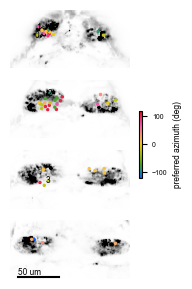

In [37]:
fig, ax = plt.subplots(n_plane, 1, figsize=(2.5, 3.5))

# go through planes
for i in range(n_plane):
    j = np.argsort(D['z'])[i]
    
    # show the anatomy
    scaled_imshow(np.rot90(np.flipud(D['stack'][j])), ax=ax[i], cmap='Greys')
    
    # clip habenula only
    ax[i].set_xlim([20,590])
    ax[i].set_ylim([400, 120])
    
    # show ROIs, colored by preferred azimuth
    x = D['coords'][j][:, 0]
    y = D['coords'][j][:, 1]
    azi_tuning = np.mean(D['bar_snip'][j][:n_azi, :, :, (t_snip>=0) * (t_snip<bar_duraiton)], axis=(1,3)) # snip is (position, repetition, ROI, time)
    pref_azi = max_azi * (np.argmax(azi_tuning, axis=0)/(n_azi-1)*2.0 - 1.0)
    sc = ax[i].scatter(D['stack'][j].shape[0]-y, D['stack'][j].shape[1]-x, s=2, c=pref_azi, vmin=-max_azi, vmax=max_azi, cmap=cc.cm.CET_R3)
    
    # no axis lines
    toggle_spines(ax[i], 0, 0, 0, 0)
    
# show colorbar for preferred azimuth
cb = plt.colorbar(sc, ax=ax, location='right', shrink=0.25)
cb.set_label('preferred azimuth (deg)')  

# show scale (nominally, image is 500 um across with 1x -- though not exact due to resonant scanning)
um_per_px = 500 / D['stack'][0].shape[1] / D['mags'][0]
ax[-1].plot([60, 60+50/um_per_px],[390,390],'k-',lw=1.5)
ax[-1].text(60, 380, '50 um')

# Show ROI position wihth numbers
for i, temp in enumerate(rois_to_show):
    pid, rid = temp
    j = np.argsort(D['z'])[pid]
    ax[pid].text(D['stack'][j].shape[0]-D['coords'][j][rid, 1],
                 D['stack'][j].shape[1]-D['coords'][j][rid, 0], str(i),
                horizontalalignment='center', verticalalignment='center',
                color=(0,0,0))

plt.savefig('../svg/ed08_a.svg')
plt.show()

## Extended Data Fig. 8b (example receptive fields of the indicated ROIs)

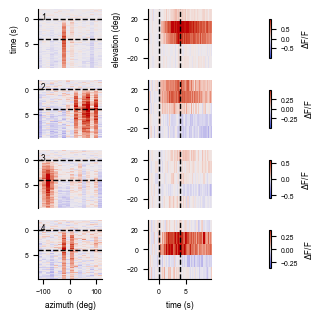

In [38]:
fig, ax = plt.subplots(len(rois_to_show), 3, figsize=(3, 3.5), width_ratios=(5,5,1))

k = 0
for pid, rid in rois_to_show:
    j = np.argsort(D['z'])[pid]
    
    # pull out the response
    resp = np.mean(D['bar_snip'][j][:, :, rid, :], axis=1)
    
    # scaling of the color
    vlim = np.percentile(np.abs(resp), 99)
    
    # show the thing
    ax[k, 0].imshow(resp[:n_azi, :].T, aspect='auto', interpolation='none', vmin=-vlim, vmax=vlim, cmap=cc.cm.CET_D1,
                extent=(-max_azi,max_azi,np.max(t_snip),np.min(t_snip)))
    im = ax[k, 1].imshow(resp[n_azi:, :],   aspect='auto', interpolation='none', vmin=-vlim, vmax=vlim, cmap=cc.cm.CET_D1,
                extent=(np.min(t_snip), np.max(t_snip), -max_ele, max_ele))
    ax[k, 0].text(-max_azi+10, 0, str(k+1))
    
    # lines indicating time & labels
    ax[k,0].plot([-max_azi, max_azi],[0,0],'k--')
    ax[k,0].plot([-max_azi, max_azi],[4,4],'k--')
    ax[k,1].plot([0,0],[-max_ele, max_ele],'k--')
    ax[k,1].plot([4,4],[-max_ele, max_ele],'k--')
        
    # colorbar
    ax[k, 2].axis('off')
    cb = plt.colorbar(im, ax=ax[k,2])
    cb.set_label('$\Delta$F/F')

    toggle_spines(ax[k,1], 0, k>=len(ax)-1, 0, 1)
    toggle_spines(ax[k,0], 0, k>=len(ax)-1, 0, 1)

    # count-up axis
    k += 1

ax[-1,0].set_xlabel('azimuth (deg)')
ax[-1,1].set_xlabel('time (s)')
ax[0,0].set_ylabel('time (s)')
ax[0,1].set_ylabel('elevation (deg)')
    
plt.subplots_adjust(wspace=1)

plt.savefig('../svg/ed08_b.svg')
plt.show()

## Extended Data Fig. 8c (Population-wide RF visualization)

In [39]:
# stack up time-averaged bar snip per fish
n_rois = []
v_tunings = []
h_tunings = []
all_tuning = []

for D in data:
    bs = np.dstack(D['bar_snip'])
    tunings = np.mean(bs[:, :, :, (t_snip>=0)*(t_snip<bar_duraiton)], axis=(1,3)).T # ROI x position
    norm_tunings = tunings / np.max(np.abs(tunings), axis=1)[:, None]
    
    peak_azi = np.argmax(np.abs(norm_tunings[:, :n_azi]), axis=1)
    peak_ele = np.argmax(np.abs(norm_tunings[:, n_azi:]), axis=1)
    
    n_rois.append(tunings.shape[0])
    all_tuning.append(tunings)
    v_tunings.append(norm_tunings[np.argsort(peak_azi), :n_azi]) # with sorting!
    h_tunings.append(norm_tunings[np.argsort(peak_ele), n_azi:])

# note that they are separately sorted 
all_tuning = np.vstack(all_tuning)
v_tunings = np.vstack(v_tunings)
h_tunings = np.vstack(h_tunings)
fish_ids_per_roi = np.hstack([np.ones(j)*i for i, j in enumerate(n_rois)])

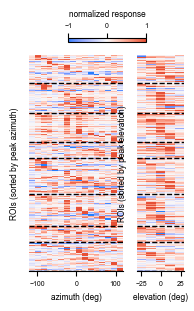

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(2, 3.5), width_ratios=(2, 1))

# azimuth
ax[0].imshow(v_tunings, interpolation='none', aspect='auto',
             vmin=-1, vmax=1, cmap=cc.cm.CET_D9,
             extent=(-max_azi, max_azi, v_tunings.shape[0], 0))
# elevation
im = ax[1].imshow(h_tunings, interpolation='none', aspect='auto',
             vmin=-1, vmax=1, cmap=cc.cm.CET_D9,
             extent=(-max_ele, max_ele, h_tunings.shape[0], 0))

cum_nrois = np.cumsum(n_rois)
for y in cum_nrois:
    ax[0].plot((-max_azi, max_azi),(y,y),'k--')
    ax[1].plot((-max_ele, max_ele),(y,y),'k--')

toggle_spines(ax[0], 0, 1, 0, 0)
toggle_spines(ax[1], 0, 1, 0, 0)

ax[0].set_ylabel('ROIs (sorted by peak azimuth)')
ax[1].set_ylabel('ROIs (sorted by peak elevation)')
ax[0].set_xlabel('azimuth (deg)')
ax[1].set_xlabel('elevation (deg)')

cb = plt.colorbar(im, location='top', ax=ax, shrink=0.5)
cb.set_label('normalized response')

plt.savefig('../svg/Ed08_c.svg')
plt.show()

## Extended Data Fig. 8d (Visualization of Scene rotation resposne)
- Concatenated for the all planes
- Sorted by azimuthal tuning
- keep using the same example fish defined above
- assuming that t_i is identical across recordings (which I think is fair given the precision of the resonant mirror)

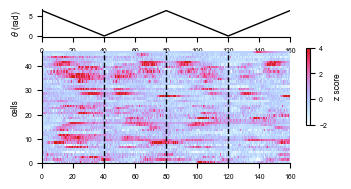

In [42]:
# Data extraction from the select fish
D = data[fid]
bs = np.dstack(D['bar_snip'])
tunings = np.mean(bs[:, :, :, (t_snip>=0)*(t_snip<bar_duraiton)], axis=(1,3)).T # ROI x position
peak_azi = np.argmax(np.abs(tunings[:, :n_azi]), axis=1)
nt =  np.vstack(D['norm_traces'])

# visualization
fig, ax = plt.subplots(2, 1, figsize=(4,2), height_ratios=(1,4))

# The heatmap
im = ax[1].imshow(nt[np.argsort(peak_azi), :][:, t_i>slog[-1]['t_start']],
             vmin=-2, vmax=4, cmap=cc.cm.CET_L19, aspect='auto', interpolation='none',
             extent=(0,slog[-1]['duration'], 0, nt.shape[0]))

# Show the theta timetrace
ax[0].plot(t_s-slog[-1]['t_start'], exp.stimulus_log['scene_rot_theta'], 'k-')
ax[0].set_xlim(0, slog[-1]['duration'])

# axis management
for i in range(3):
    ax[1].plot([40*(i+1), 40*(i+1)], [0, nt.shape[0]], 'k--')
toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 1, 0, 1)
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('z score')

ax[1].set_ylabel('cells')
ax[0].set_ylabel(r'$\theta$ (rad)')
ax[0].set_xlabel('time (s)')

plt.savefig('../svg/ed08_d.svg')
plt.show()

## Extended Data Fig. 8e (Correlation-based naive decoding)

In [43]:
# Quantiative analysis using naive argmax decoding
# assumes identical configurations from the all recordings (which are met)

# pull out scene part of the trace
is_scene = t_i > slog[-1]['t_start']
scene_t = t_i[is_scene] - slog[-1]['t_start']

# downsample neural data to 1 hz
t_1hz = np.arange(0, max(scene_t), 1)
t_bin = np.arange(0, max(scene_t)+1, 1) - 0.5

# downsample theta (this is the fastest)
ds_theta = binned_statistic(t_s[t_s>slog[-1]['t_start']]-slog[-1]['t_start'],
                 exp.stimulus_log['scene_rot_theta'].to_numpy()[t_s>slog[-1]['t_start']],
                 bins=t_bin)[0]

# go through all fish
for i, D in enumerate(data):
    # Scene response of visual neurons, concatenated across recordings
    scene_resp =  np.vstack(D['norm_traces'])[:, is_scene]
    
    # downsample scene response to 1 Hz
    ds_resp = binned_statistic(scene_t, scene_resp, bins=t_bin)[0]
    
    # calculate correlation
    ds_corr = np.corrcoef(ds_resp.T)
    
    # pull out argmax angle for decoding
    decoded_theta = ds_theta[np.argmax(ds_corr[:40, :], axis=0)]
    
    data[i]['ds_corr'] = ds_corr
    data[i]['decoded_theta'] = decoded_theta    

mean_abs_error = np.asarray([np.mean(np.abs((D['decoded_theta']-ds_theta+np.pi)%(2*np.pi)-np.pi)[40:]) for D in data])

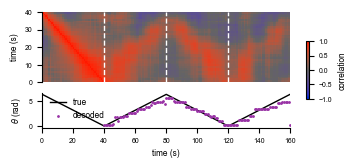

In [45]:
# Data extraction from the same example fish
D = data[fid]

# visualization
fig, ax = plt.subplots(2, 1, figsize=(4,1.5), height_ratios=(2,1))

# correlation heat map
im = ax[0].imshow(D['ds_corr'][:40, :],
             vmin=-1, vmax=1, cmap=cc.cm.CET_D8, aspect='auto', interpolation='none',
             extent=(0, 160, 0, 40))

# true and decoded theta
ax[1].plot(t_s-slog[-1]['t_start'], exp.stimulus_log['scene_rot_theta'], 'k-', label='true')
ax[1].scatter(t_1hz[40:], D['decoded_theta'][40:], s=1, zorder=3, color=color_getter(8), label='decoded')

# axis management
ax[1].set_xlim(0, slog[-1]['duration'])
ax[1].legend(loc='lower left')
for i in range(3):
    ax[0].plot([40*(i+1), 40*(i+1)], [0, 40], 'w--')
toggle_spines(ax[0], 0, 0, 0, 1)
toggle_spines(ax[1], 0, 1, 0, 1)
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('correlation')


ax[0].set_ylabel('time (s)')
ax[1].set_ylabel(r'$\theta$ (rad)')
ax[1].set_xlabel('time (s)')

plt.savefig('../svg/ed08_e.svg')
plt.show()

## Extended Data Fig. 8f (Statistics on the decoding performance)

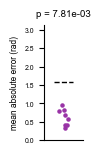

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(0.5, 1.5))
ax.scatter(np.random.rand(len(mean_abs_error))-0.5, mean_abs_error, s=5, color=color_getter(8))
ax.plot([-1,1],[np.pi/2,np.pi/2],'k--')

ax.set_xlim([-2,2])
ax.set_ylim([0,np.pi])
ax.set_xticks([])
ax.set_ylabel('mean absolute error (rad)')
ax.set_title('p = {:0.2e}'.format(wilcoxon(mean_abs_error-np.pi/2)[1]))
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed08_f.svg')
plt.show()